# Custom observation models

While *bayesloop* provides a number of observation models like `Poisson` or `AR1`, many applications call for different distributions, possibly with some parameters set to fixed values (e.g. with a mean value set to zero). The [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) and the [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html) modules include a large number of continuous as well as discrete probability distributions. The observation model classes `SciPy` and `SymPy` allow to create observation models to be used in *bayesloop* studies on-the-fly, just by passing the desired `scipy.stats` distribution (and setting values for fixed parameters, if necessary), or by providing a `sympy.stats` random variable, respectively. Note that these classes can only be used to model statistically independent observations. 

In cases where neither `scipy.stats` nor `sympy.stats` provide the needed model, one can further define a custom observation model by stating a likelihood function in terms of arbitrary [NumPy](http://www.numpy.org/) functions, using the `NumPy` class.

## Sympy.stats random variables
The [SymPy](http://www.sympy.org/en/index.html) module introduces symbolic mathematics to Python. Its sub-module [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) covers a wide range of discrete and continuous random variables. In the following, we re-define the observation model of the coal mining study `S` defined above, but this time use the `sympy.stats` version of the Poisson distribution:

In [1]:
import bayesloop as bl
import numpy as np
import sympy.stats
from sympy import Symbol

rate = Symbol('lambda', positive=True)
poisson = sympy.stats.Poisson('poisson', rate)

L = bl.om.SymPy(poisson, 'lambda', bl.oint(0, 6, 1000))

    + Trying to determine Jeffreys prior. This might take a moment...
    + Successfully determined Jeffreys prior: 1/sqrt(lambda). Will use corresponding lambda function.


First, we specify the only parameter of the Poisson distribution (denoted $\lambda$) symbolically as a positive real number. Note that providing the keyword argument `positive=True` is important for SymPy to define the Poisson distribution correctly (not setting the keyword argument correctly results in a error). Having defined the parameter, a random variable based on the Poisson distribution is defined. This random variable is then passed to the `SymPy` class of the *bayesloop* observation models. Just as for the built-in observation models of *bayesloop*, one has to specify the parameter names and values (in this case, `lambda` is the only parameter).

Note that upon creating an instance of the observation model, *bayesloop* automatically determines the correct [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) for the Poisson model:

$$
p(\lambda) \propto 1/\sqrt{\lambda}
$$

This calculation is done symbolically and therefore represents an important advantage of using the `SymPy` module within *bayesloop*. This behavior can be turned off using the keyword argument `determineJeffreysPrior`, in case one wants to use a flat parameter prior instead or in the case that the automatic determination of the prior takes too long:
```
M = bl.om.SymPy(poisson, 'lambda', bl.oint(0, 6, 1000), determineJeffreysPrior=False)
```
Alternatively, you can of course provide a custom prior via the keyword argument `prior`. This will switch off the automatic determination of the Jeffreys prior as well:
```
M = bl.om.SymPy(poisson, 'lambda', bl.oint(0, 6, 1000), prior=lambda x: 1/x)
```
See also [this tutorial](priordistributions.html) for further information on prior distributions. Having defined the observation model, it can be used for any type of study introduced above. Here, we reproduce the result of the [regime-switching example](changepointstudy.html#Exploring-possible-change-points) we discussed before. We find that the parameter distributions as well as the model evidence is identical - as expected:

+ Created new study.
+ Successfully imported example data.
+ Observation model: poisson. Parameter(s): ('lambda',)
+ Transition model: Regime-switching model. Hyper-Parameter(s): ['log10pMin']
+ Started new fit:
    + Formatted data.
    + Set prior (function): <lambda>. Values have been re-normalized.



    + Finished forward pass.
    + Log10-evidence: -80.63781



    + Finished backward pass.
    + Computed mean parameter values.


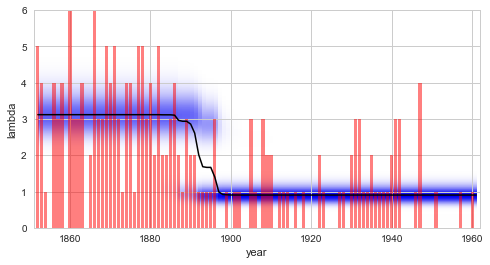

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

S = bl.Study()
S.loadExampleData()

T = bl.tm.RegimeSwitch('log10pMin', -7)

S.set(L, T)
S.fit()

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plot('lambda')
plt.xlim([1851, 1962])
plt.xlabel('year');

Finally, it is important to note that the `SymPy` module can also be used to create random variables for which some parameters have user-defined fixed values. The following example creates a normally distributed random variable with a fixed mean value $\mu = 4$, leaving only the standard deviation as a free parameter of the resulting observation model (which is assigned the parameter interval ]0, 3[):
```
mu = 4
std = Symbol('stdev', positive=True)

normal = sympy.stats.Normal('normal', mu, std)
L = bl.om.SymPy(normal, 'stdev', bl.oint(0, 3, 1000))
```

## Scipy.stats probability distributions
We continue by describing the use of probability distributions of the `scipy.stats` module. Before we show some usage examples, it is important to note here that `scipy.stats` does not use the canonical parameter names for probability distributions. Instead, all continuous distributions have two parameters denoted `loc` (for shifting the distribution) and `scale` (for scaling the distribution). Discrete distributions only support `loc`. While some distributions may have additional parameters, `loc` and `scale` often take the role of known parameters, like *mean* and *standard deviation* in case of the normal distribution. In `scipy.stats`, you do not have to set `loc` or `scale`, as they have default values `loc=0` and `scale=1`. In *bayesloop*, however, you will have to provide values for these parameters, if you want either of them to be fixed and not treated as a variable.

As a first example, we re-define the observation model of the coal mining study `S` defined above, but this time use the `scipy.stats` version of the Poisson distribution. First, we check the parameter names:

In [3]:
import scipy.stats

scipy.stats.poisson.shapes

'mu'

In `scipy.stats`, the rate of events in one time interval of the Poisson distribution is called *mu*. Additionally, as a discrete distribution, `stats.poisson` has an additional parameter `loc` (which is **not** shown by `.shapes` attribute!). As we do not want to shift the distribution, we have to set this parameter to zero in *bayesloop* by passing a dictionary for fixed parameters when initializing the class instance. As for the SymPy model, we have to pass the names and values of all free parameters of the model (here only `mu`):

+ Observation model: poisson. Parameter(s): ('mu',)
+ Started new fit:
    + Formatted data.
    + Set uniform prior with parameter boundaries.



    + Finished forward pass.
    + Log10-evidence: -80.49098



    + Finished backward pass.
    + Computed mean parameter values.


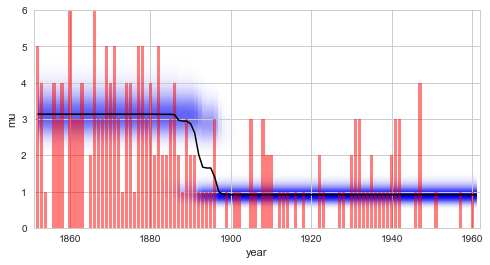

In [4]:
L = bl.om.SciPy(scipy.stats.poisson, 'mu', bl.oint(0, 6, 1000), fixedParameters={'loc': 0})
S.set(L)
S.fit()

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plot('mu')
plt.xlim([1851, 1962])
plt.xlabel('year');

Comparing this result with the [regime-switching example](changepointstudy.html#Exploring-possible-change-points), we find that the model evidence value obtained using the `scipy.stats` implementation of the Poisson distribution is *different* from the value obtained using the built-in implementation or the `sympy.stats` version. The deviation is explained by a different prior distribution for the parameter $\lambda$. While both the built-in version and the `sympy.stats` version use the [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) of the Poisson model, the `scipy.stats` implementation uses a flat prior instead. Since the `scipy.stats` module does not provide symbolic representations of probability distributions, *bayesloop* cannot determine the correct Jeffreys prior in this case. Custom priors are still possible, using the keyword argument `prior`.

## NumPy likelihood functions

In some cases, the data at hand cannot be described by a common statistical distribution contained in either `scipy.stats` or `sympy.stats`. In the following example, we assume normally distributed data points with known standard deviation $\sigma$, but unknown mean $\mu$. Additionally, we suspect that the data points may be serially correlated and that the correlation coefficient $\rho$ possibly changes over time. For this multivariate problem with the known standard deviation as "extra" data points, we need more flexibility than either the `SymPy` or the `SciPy` class of `bayesloop` can offer. Instead, we may define the likelihood function of the observation model directly, with the help of [NumPy](http://www.numpy.org/) functions.

First, we simulate $1000$ random variates with $\mu=3$, $\sigma=1$, and a linearly varying correlation coefficient $\rho$:

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  del sys.path[0]


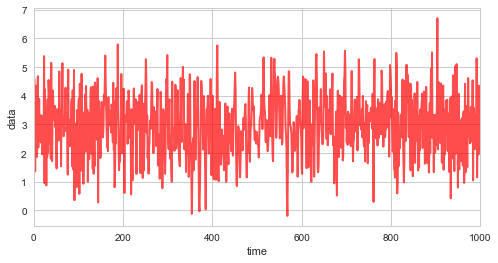

In [5]:
n = 1000

# parameters
mean = 3
sigma = 1
rho = np.concatenate([np.linspace(-0.5, 0.9, 500), np.linspace(0.9, -0.5, 499)])

# covariance matrix
cov = np.diag(np.ones(n)*sigma**2.) + np.diag(np.ones(n-1)*rho*sigma**2., 1) + np.diag(np.ones(n-1)*rho*sigma**2., -1)

# random variates
np.random.seed(123456)
obs_data = np.random.multivariate_normal([mean]*n, cov)

plt.figure(figsize=(8, 4))
plt.plot(obs_data, c='r', alpha=0.7, lw=2)
plt.xlim([0, 1000])
plt.xlabel('time')
plt.ylabel('data');

Before we create an observation model to be used by `bayesloop`, we define a pure Python function that takes a segment of data as the first argument, and NumPy arrays with parameter grids as further arguments. Here, one data segment includes two subsequent data points `x1` and `x2`, and their known standard deviations `s1` and `s2`. The likelihood function we evaluate states the probability of observing the current data point `x2`, given the previous data point `x1`, the known standard deviations `s2`, `s1` and the parameters $\mu$ and $\rho$:

$$P(x_2~|~x_1, s_2, s_1, \mu, \rho) = \frac{P(x_2, x_1~|~s_2, s_1, \mu, \rho)}{P(x_1~|~s_1, \mu)}~,$$

where $P(x_2, x_1~|~s_2, s_1, \mu, \rho)$ denotes the [bivariate normal distribution](http://mathworld.wolfram.com/BivariateNormalDistribution.html), and $P(x_1~|~s_1, \mu)$ is the marginal, univariate normal distribution of $x_1$. The resulting distribution is expressed as a Python function below. Note that all mathematical functions use NumPy functions, as the function needs to work with arrays as input arguments for the parameters:

In [6]:
def likelihood(data, mu, rho):
    x2, x1, s2, s1 = data
    
    exponent = -(((x1-mu)*rho/s1)**2. - (2*rho*(x1-mu)*(x2-mu))/(s1*s2) + ((x2-mu)/s2)**2.) / (2*(1-rho**2.))
    norm = np.sqrt(2*np.pi)*s2*np.sqrt(1-rho**2.)
    
    like = np.exp(exponent)/norm
    return like

As `bayesloop` still needs to know about the parameter boundaries and discrete values of the parameters $\mu$ and $\rho$, we need to create an observation model from the custom likelihood function defined above. This can be done with the `NumPy` class:

In [7]:
L = bl.om.NumPy(likelihood, 'mu', bl.cint(0, 6, 100), 'rho', bl.oint(-1, 1, 100))

Before we can load the data into a `Study` instance, we have to format data segments in the order defined by the likelihood function:
```
[[x1, x0, s1, s0], 
 [x2, x1, s2, s1],
 [x3, x2, s3, s2],
 ...]
```
Note that in this case, the standard deviation $\sigma = 1$ for all time steps.

In [8]:
data_segments = input_data = np.array([obs_data[1:], obs_data[:-1], [sigma]*(n-1), [sigma]*(n-1)]).T

Finally, we create a new `Study` instance, load the formatted data, set the custom observation model, set a suitable transition model, and fit the model parameters:

In [9]:
S = bl.Study()
S.loadData(data_segments)
S.set(L)

T = bl.tm.GaussianRandomWalk('d_rho', 0.03, target='rho')
S.set(T)

S.fit()

+ Created new study.
+ Successfully imported array.
+ Observation model: likelihood. Parameter(s): ('mu', 'rho')
+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['d_rho']
+ Started new fit:
    + Formatted data.
    + Set uniform prior with parameter boundaries.



    + Finished forward pass.
    + Log10-evidence: -605.35934



    + Finished backward pass.
    + Computed mean parameter values.


Plotting the true values of $\rho$ used in the simulation of the data together with the inferred distribution (and posterior mean values) below, we see that the custom model accurately infers the time-varying serial correlation in the data.

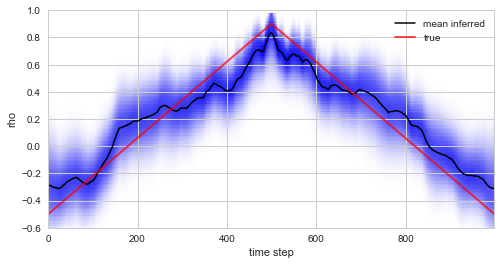

In [10]:
plt.figure(figsize=(8, 4))
S.plot('rho', label='mean inferred')
plt.plot(rho, c='r', alpha=0.7, lw=2, label='true')
plt.legend()
plt.ylim([-.6, 1]);

Finally, we note that the `NumPy` observation model allows to access multiple data points at once, as we can pass arbitrary data segments to it (in the example above, each data segment contained the current and the previous data point). This also means that there is no check against looking at the data points twice, and the user has to make sure that the likelihood function at time $t$ always states the probability of **only the current** data point:

$$ P(\text{data}_{t}~|~\{\text{data}_{t'}\}_{t'<t}, \text{parameters})$$

If the left side of this conditional probability contains data points from more than one time step, the algorithm will look at each data point more than once, and this generally results in an underestimation of the uncertainty teid to the model parameters!